### Day 1: Automate EDA & Report Generation — Build a script to summarize & visualize datasets.

### Scoping

Exploratory Data Analysis (EDA) is a fundamental process in any data science workflow. It involves investigating and summarizing the key characteristics of a dataset, often using visual methods and descriptive statistics. EDA helps uncover patterns, detect anomalies, test hypotheses, and check assumptions, ultimately guiding more informed modeling decisions.

The primary goal of this project is to **clean the data** and **analyze it** to identify meaningful patterns and insights. Report generation in this context can take two forms:

- **Visual Report:** Created using tools like Tableau for intuitive, interactive data storytelling.
- **Written Report:** A structured summary of the dataset, highlighting key statistics and relationships between variables.

#### Steps to Follow:

- **Support Multiple Data Formats:** Ensure the pipeline handles different data formats such as CSV, Excel, or JSON.
- **Data Cleaning:**
  - Enforce correct data types (e.g., `Int64`, `float64`, `datetime64[ns]`).
  - Remove duplicates.
  - Handle missing values appropriately.
  - Strip trailing or leading spaces from string/object columns.

- **Data Analysis:**
  - Summarize the distribution (spread) of numeric variables.
  - Provide counts/frequencies of categorical variables.
  - Plot numeric variables against each other to assess correlation.
  - Plot numeric variables against categorical ones to explore relationships.
  - For categorical features with many unique values, display **top 10** or **bottom 10** categories as needed.

- **Report Generation:**
  - Generate written summaries and/or visual dashboards depending on the target audience and delivery method.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from dateutil.parser import parse
from scipy.stats import shapiro, normaltest, ks_2samp


In [2]:
def load_data(path):
    format = path.split('.')[-1]
    if format.lower() == 'csv':
        try:
            data = pd.read_csv(path)
        except:
            print('Error: file not found')
    elif format.lower() == 'json':
        try:
            data = pd.read_json(path)
        except:
            print('Error: file not found')
    elif format.lower() == 'xlsx':
        try:
            data = pd.read_excel(path)
        except:
            print('Error: file not found')
    else:
        print('Error! Format not supported')
    return data

In [4]:
def clean_empty_strings(df):
    """
    Remove empty strings from the DataFrame.
    """
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].replace(r'^\s*$', np.nan, regex=True)
    return df

In [5]:
def infer_column_type(df):
    """
    Infers the most likely type of each column in a DataFrame based on regex matching and `pd.to_datetime()`.
    Returns a dictionary with column names and their inferred types.
    """

    float_pattern = re.compile(r"^-?\d+\.\d+$")  # Matches float (e.g., 12.3, -45.67)
    int_pattern = re.compile(r"^-?\d+$")  # Matches integers (e.g., 12, -45)
    date_patterns = [
        re.compile(r"^\d{4}-\d{2}-\d{2}$"),  # YYYY-MM-DD
        re.compile(r"^\d{2}-\d{2}-\d{4}$"),  # DD-MM-YYYY
        re.compile(r"^\d{2}/\d{2}/\d{4}$"),  # MM/DD/YYYY
        re.compile(r"^\d{2} [A-Za-z]{3,} \d{4}$")  # DD Month YYYY
    ]

    column_types = {}

    for col in df.columns:
        counts = {'float': 0, 'int': 0, 'datetime': 0, 'string': 0}
        col_data = df[col].dropna().astype(str)  # Convert non-null values to string


        # Count how many values match each type
        counts['float'] = col_data.str.match(float_pattern).sum()
        counts['int'] = col_data.str.match(int_pattern).sum()
        counts['datetime'] = sum(any(pattern.match(val) for pattern in date_patterns) for val in col_data)

        # Fallback: Try parsing with dateutil (but exclude long numbers)
        counts['datetime'] += sum(1 for val in col_data if try_parse_date(val))

        # Remaining are strings
        counts['string'] = len(col_data) - sum(counts.values())

        # **Check that at least 70% of values match a date format before converting**
        if counts['datetime'] > len(col_data) * 0.7 and ((counts['int'] < len(col_data) * 0.2) and (counts['float'] < len(col_data) * 0.2)):  
            try:
                pd.to_datetime(df[col], errors='raise')  # If this works, it's a datetime column
                inferred_type = 'datetime'
            except (ValueError, TypeError):
                inferred_type = max(counts, key=counts.get)
        else:
            inferred_type = max(counts, key=counts.get)

        column_types[col] = inferred_type  # Store result for each column

    return column_types

def try_parse_date(value):
    """Helper function to check if a value can be parsed as a date while avoiding small and large numbers."""
    try:
        if value.isdigit():
            num = int(value)
            if 1900 <= num <= 2100:  # Likely a year (e.g., 1995, 2024)
                return True
            return False  # Avoids classifying small numbers (1, 2, 18) as dates
        parse(value, fuzzy=False)
        return True
    except (ValueError, TypeError):
        return False

In [6]:
def validate_dataframe(df):
    """
    Checks if each column's inferred type matches its actual dtype,
    and attempts to cast columns to the expected type.
    """
    inferred_type = infer_column_type(df)
    type_mapping = {
        'int': 'Int64',
        'float': 'float64',
        'datetime': 'datetime64[ns]',
        'string': 'string'
    }

    for col in df.columns:
        actual_dtype = df[col].dtype
        expected = inferred_type.get(col)

        if str(actual_dtype) == type_mapping.get(expected, str(actual_dtype)):
            continue

        if expected == 'int' and actual_dtype == 'object':
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

        elif expected == 'float':
            df[col] = pd.to_numeric(df[col], errors='coerce')

        elif expected == 'datetime':
            df[col] = pd.to_datetime(df[col], errors='coerce')

        else:
            df[col] = df[col].astype(type_mapping.get(expected, 'object'))

    return df


In [7]:
def is_normal_distribution(data, threshold=0.05):
    """
    Checks if a dataset follows a normal distribution using multiple tests.
    
    Returns:
        True  -> Data is normal
        False -> Data is NOT normal
    """
    data = data.dropna()  # Remove NaNs before testing

    if len(data) < 3:  # Too few values to test
        return False  

    if len(data) < 50:  
        stat, p = shapiro(data)  # Shapiro-Wilk for small samples
    elif len(data) < 1000:  
        stat, p = normaltest(data)  # D'Agostino K² for medium samples
    else:  
        stat, p = ks_2samp(data, np.random.normal(np.mean(data), np.std(data), size=len(data)))  # KS Test for large samples

    return p >= threshold  # If p >= 0.05, data is normal


In [8]:
def remove_id_columns(df):
    """
    Detects and removes ID-like columns from a DataFrame.
    It considers a column as an ID if:
    - The column name contains common identifier keywords (e.g., 'id', 'identifier', 'index').
    - The column contains a steadily increasing sequence of numbers and is not a datetime column.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
    
    Returns:
        pd.DataFrame: DataFrame with ID-like columns removed.
    """
    
    # Common ID-like column name patterns
    id_patterns = ["id", "identifier", "index", "user_id", "customer_id", "record_id"]
    
    # Detect columns based on name
    id_columns = [col for col in df.columns if any(re.search(pattern, col, re.IGNORECASE) for pattern in id_patterns)]
    
    # Detect columns with steadily increasing numbers
    for col in df.select_dtypes(include=['int64', 'float64']):
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            continue  # Skip datetime columns
        
        # Check if numbers are strictly increasing
        if df[col].is_monotonic_increasing and df[col].nunique() == len(df) and col not in id_columns:
            print("ID column detected")
            id_columns.append(col)
    
    # Drop detected ID columns
    df_cleaned = df.drop(columns=id_columns, errors='ignore')
    
    print(f"Removed ID-like columns: {id_columns}")
    return df_cleaned


In [9]:
def clean_data(df):
    df = remove_id_columns(df)
    columns = list(df.columns)
    for i in columns:
        if 'Unnamed: ' in i:
            df = df.drop(i, axis=1)
            columns.remove(i)
        else:
            pass
    numerical_columns = [i for i in columns if df[i].dtype in ['Int64', 'float64']]
    categorical_columns = [i for i in columns if df[i].dtype == 'string']
    date_columns = [i for i in columns if df[i].dtype == 'datetime64[ns]']
    df = df.drop_duplicates().reset_index(drop=True)
    na = df.isna().sum().sum()
    if na > 0:
        for i in columns:
            if i in numerical_columns:
                if is_normal_distribution(df[i]):
                    df[i] = df[i].fillna(df[i].mean())
                else:
                    df[i] = df[i].fillna(df[i].median())
            elif i in date_columns:
                df[i] = df[i].fillna(df[i].mode())
            else:
                df[i].fillna(df[i].fillna('Unknown'))
    else:
        pass
    
    for i in categorical_columns:
        df[i] = df[i].str.strip().str.lower()
    
    return df

In [13]:
def summarize_dataset(df):
    """
    Generates a summary of the dataset with:
    - Basic info and statistics
    - Pairwise scatter plots for numeric columns
    - KDE plots for numeric distributions
    - Time series plots (if date columns exist)
    - Bar plots for categorical vs numeric columns
    """
    
    # Basic dataset info
    print("\nDataset Info:")
    print(df.info())
    print("\nSummary Statistics:")
    print(df.describe())
    
    # Identify column types
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    date_cols = df.select_dtypes(include=['datetime64']).columns.tolist()

    for col in categorical_cols:
        plt.figure(figsize=(8,5))
        sns.countplot(x=df[col])
        plt.title(f"Count Plot: {col}")
        plt.show()
    
    # Scatter plots for numeric columns
    if len(numeric_cols) > 1:
        sns.pairplot(df[numeric_cols[:6]])
        plt.suptitle("Pairwise Scatter Plots", y=1.02)
        plt.show()
    
    # KDE plots for numeric columns
    for col in numeric_cols:
        plt.figure(figsize=(6,4))
        sns.kdeplot(df[col], fill=True)
        plt.title(f"KDE Plot: {col}")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.show()
    
    # Time series plots
    if date_cols and numeric_cols:
        for date_col in date_cols:
            for num_col in numeric_cols:
                plt.figure(figsize=(10,5))
                sns.lineplot(x=df[date_col], y=df[num_col])
                plt.title(f"Time Series: {num_col} over {date_col}")
                plt.xlabel(date_col)
                plt.ylabel(num_col)
                plt.xticks(rotation=45)
                plt.show()
    
    # Bar plots for categorical vs numeric columns
    if categorical_cols and numeric_cols:
        for cat_col in categorical_cols:
            for num_col in numeric_cols:
                plt.figure(figsize=(8,5))
                sns.barplot(x=df[cat_col], y=df[num_col], estimator=sum)
                plt.title(f"Bar Plot: {num_col} by {cat_col}")
                plt.xticks(rotation=45)
                plt.show()
    
    df.to_csv("clean_dataset.csv")

In [ ]:
def report_generation(datapath):
    """
    Generates a cleaned and summarized report from a raw dataset.

    This function performs the following steps:
    1. Loads the dataset from the provided file path.
    2. Replaces empty strings or whitespace-only values with NaN.
    3. Validates and standardizes column data types.
    4. Applies additional cleaning logic (e.g., formatting, corrections).
    5. Produces a summarized version of the dataset for reporting.

    Parameters:
        datapath (str): The file path to the raw dataset.

    Returns:
        DataFrame: A cleaned and summarized pandas DataFrame.
    """
    df = load_data(datapath)
    df = clean_empty_strings(df)
    df = validate_dataframe(df)
    df = clean_data(df)
    df = summarize_dataset(df)

Removed ID-like columns: ['opioids']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   age                   10000 non-null  Int64 
 1   weight                10000 non-null  Int64 
 2   sex                   10000 non-null  string
 3   height                10000 non-null  Int64 
 4   sys_bp                10000 non-null  Int64 
 5   smoker                10000 non-null  string
 6   nic_other             10000 non-null  string
 7   num_meds              10000 non-null  Int64 
 8   occup_danger          10000 non-null  Int64 
 9   ls_danger             10000 non-null  Int64 
 10  cannabis              10000 non-null  string
 11  other_drugs           10000 non-null  string
 12  drinks_aweek          10000 non-null  Int64 
 13  addiction             10000 non-null  string
 14  major_surgery_num     10000 non-nul

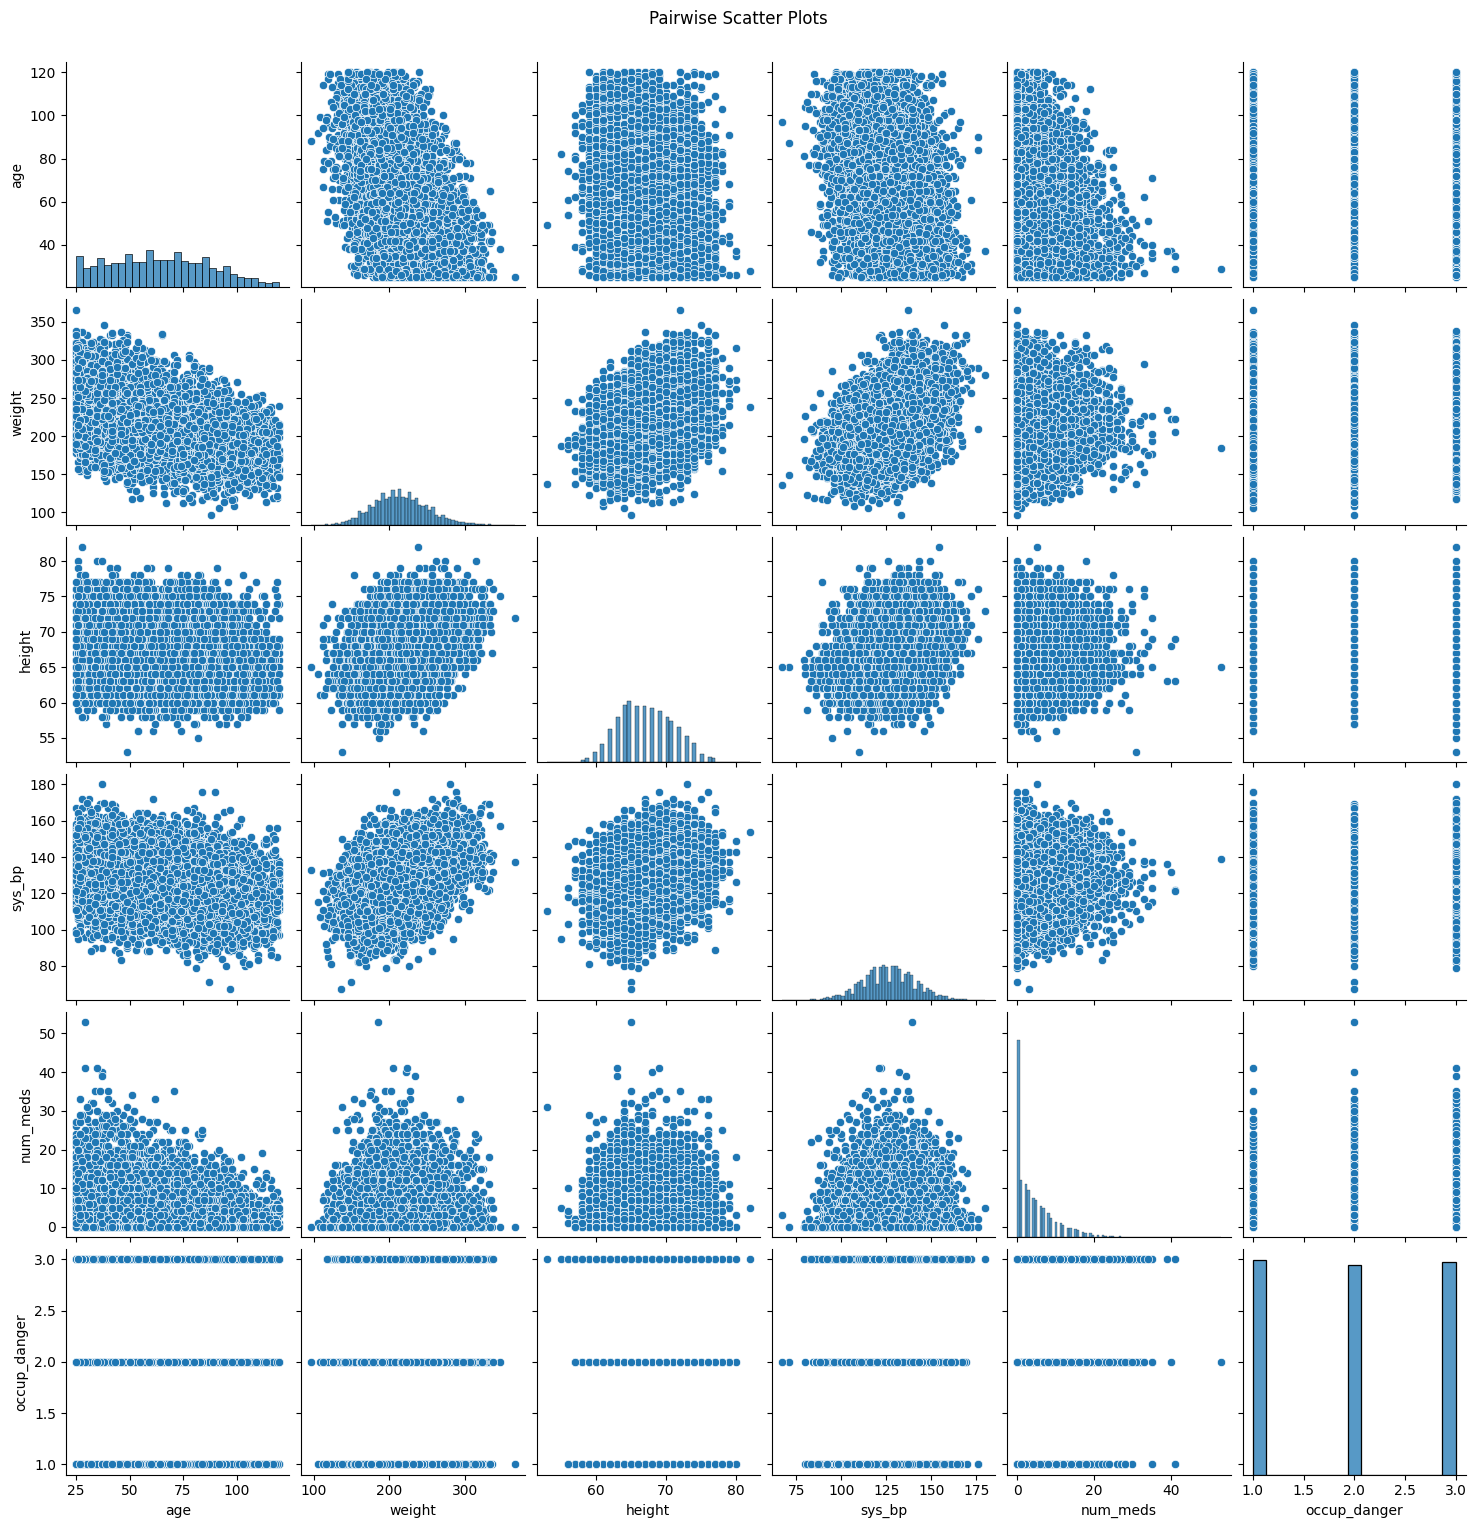

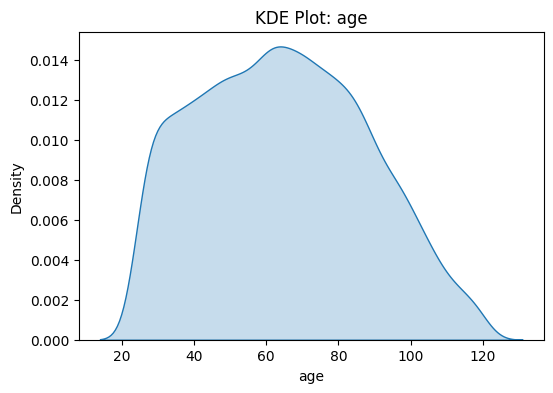

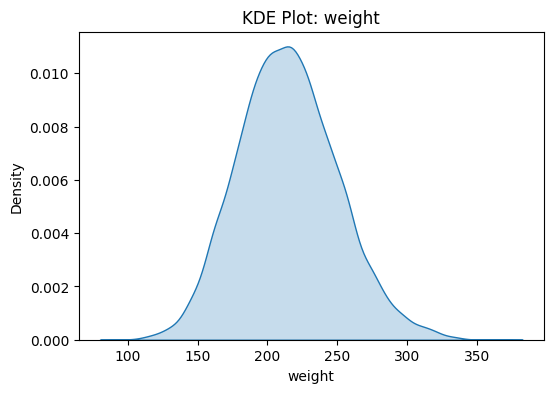

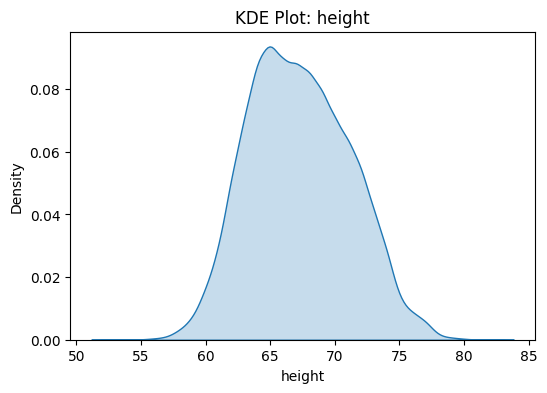

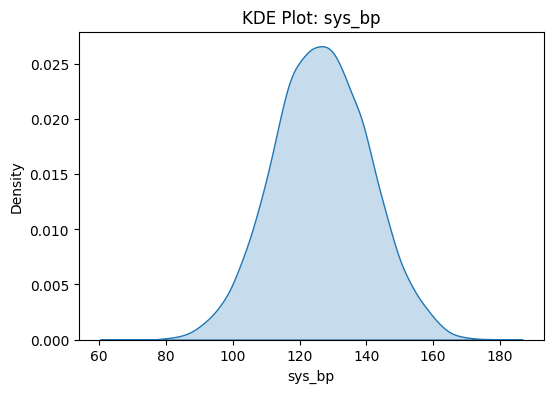

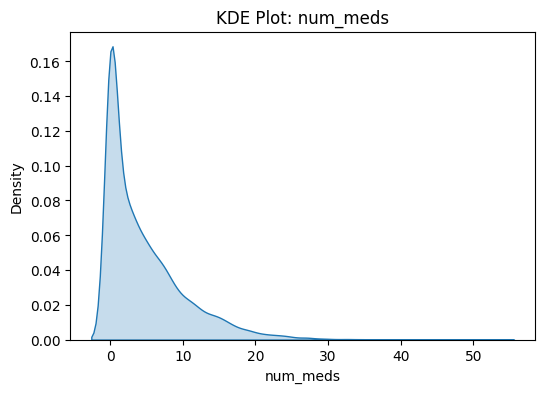

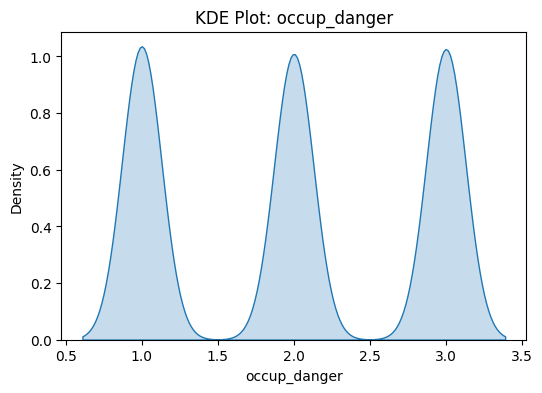

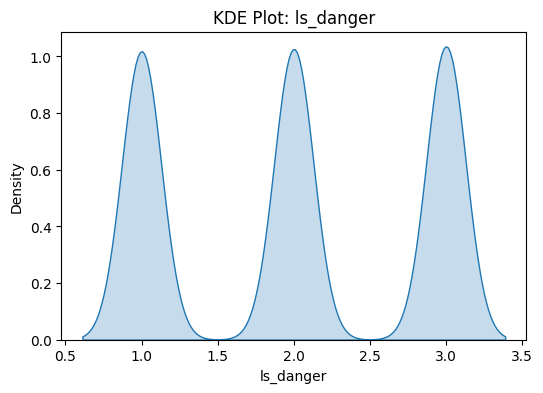

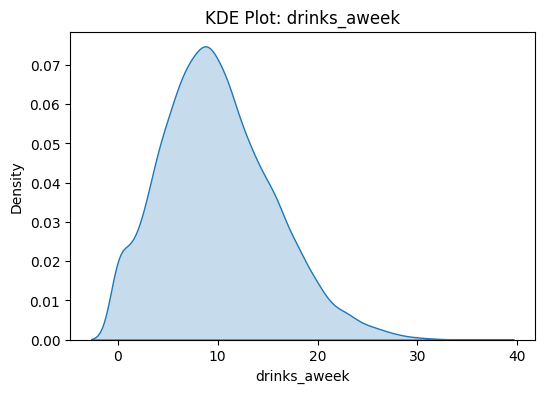

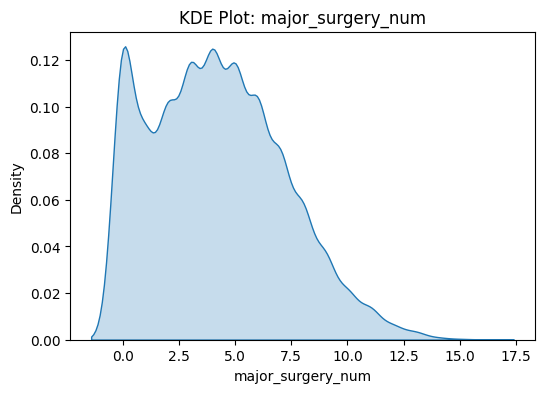

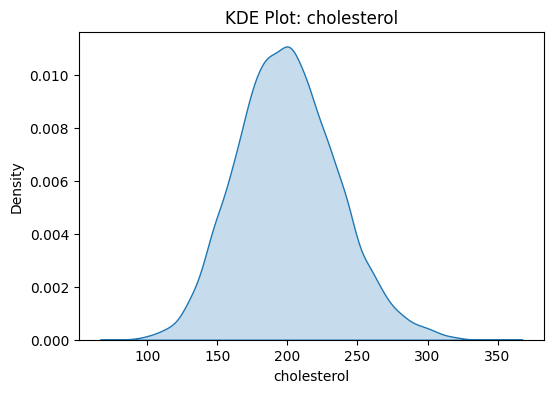

In [12]:
report_generation('data.json')